In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
data = pd.read_csv("EV_cars_India_2023.csv")
data.head()

C:\Users\chirag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Car_name,Car_price,Batter_cap,Drive_range,Power,Charge_time,transmission,Boot_space,Top_speed
0,MG Comet EV,7.98 lakh,17.3 kWh,230 km/full charge,41.42 Bhp,7 Hours,Automatic,NaN,NaN
1,Tata Tiago EV,8.69 - 11.99 lakh,19.2 KWh,250 km/full charge,60.34 - 73.75 Bhp,58 Min(10-80%),240 L (Liters),Automatic,NaN
2,Tata Tigor EV,12.49 - 13.75 lakh,26 kWh,315 km/full charge,73.75 Bhp,7.5h,316 L (Liters),Automatic,NaN
3,MG ZS EV,23.38 - 27.40 lakh,50.3 kWh,461 km/full charge,174.33 Bhp,8.5 to 9 Hours,Automatic,NaN,NaN
4,BYD Atto 3,33.99 - 34.49 lakh,60.48 kWh,521 km/full charge,201.15 Bhp,9.5-10 Hours,440L L (Liters),Automatic,NaN


# DATA PREPROCESSING 

In [2]:
data['Brand'] = data['Car_name'].apply(lambda x: re.findall(r'^\w+', x)[0])
data['Model'] = data['Car_name'].apply(lambda x: re.findall(r'\w+$', x)[0])
data = data.drop(columns='Car_name')


In [3]:
# Define a function to clean and convert the car price
def convert_car_price(price):
    if ' - ' in price:
        # Extract the numeric values from the range
        values = re.findall(r'\d+\.\d+|\d+', price)
        average = (float(values[0]) + float(values[1])) / 2
        return average * 100000
    elif 'lakh' in price:
        # Extract the numeric value from the string
        value = float(re.findall(r'\d+\.\d+|\d+', price)[0])
        return value * 100000
    elif 'cr' in price:
        value = float(re.findall(r'\d+\.\d+|\d+', price)[0])
        return value * 10000000
    else:
        return price

# Apply the function to the 'Car_price' column
data['Car_price'] = data['Car_price'].apply(convert_car_price)



In [4]:
print(data['Car_price'])

0       798000.0
1      1034000.0
2      1312000.0
3      2539000.0
4      3424000.0
5      2393500.0
6      1749000.0
7      1801500.0
8       199500.0
9     17000000.0
10     7570000.0
11     2915000.0
12      191500.0
13    19000000.0
14      929500.0
15      450000.0
16     1584000.0
17     4495000.0
18     6345000.0
19    12000000.0
20    19000000.0
21     5250000.0
22      111000.0
23     1213000.0
24     5690000.0
25      120000.0
26     3950000.0
27      479000.0
28     7450000.0
29     9950000.0
Name: Car_price, dtype: float64


In [5]:


data = data.drop(['transmission', 'Boot_space','Top_speed'], axis=1)


In [6]:
data['Batter_cap'] = data['Batter_cap'].fillna(method='ffill')
data['Batter_cap'] = data['Batter_cap'].astype(str)

# Define a function to clean and convert the battery capacity
def clean_battery_capacity(capacity):
    value = re.findall(r'\d+\.\d+|\d+', capacity)[0]
    return float(value)

data['Batter_cap'] = data['Batter_cap'].apply(clean_battery_capacity)
print(data['Batter_cap'])

0      17.30
1      19.20
2      26.00
3      50.30
4      60.48
5      39.20
6      34.50
7      40.50
8      17.30
9      19.20
10     26.00
11     50.30
12     60.48
13     39.20
14     34.50
15     40.50
16     71.70
17     29.20
18     77.40
19    200.00
20    200.00
21     32.60
22     77.40
23    200.00
24    200.00
25     32.60
26    107.80
27     93.40
28     93.40
29     83.90
Name: Batter_cap, dtype: float64


In [7]:
data['Drive_range'] = data['Drive_range'].astype(str)

# Define a function to clean and convert the drive range
def clean_drive_range(range_str):
    # Extract the numeric values from the string
    values = re.findall(r'\d+\.?\d*', range_str)

    if len(values) > 1:
        # Calculate the average of the extracted numeric values
        average_range = sum(float(value) for value in values) / len(values)
        return average_range
    elif len(values) == 1:
        return float(values[0])
    else:
        return 0

data['Drive_range'] = data['Drive_range'].apply(clean_drive_range)
print(data['Drive_range'])

0     230.0
1     250.0
2     315.0
3     461.0
4     521.0
5     452.0
6     375.0
7     453.0
8     230.0
9     250.0
10    315.0
11    461.0
12    521.0
13    452.0
14    375.0
15    453.0
16    415.0
17    320.0
18    708.0
19    398.5
20    607.5
21    270.0
22    708.0
23    398.5
24    607.5
25    270.0
26    857.0
27    444.0
28    321.5
29    541.5
Name: Drive_range, dtype: float64


In [8]:
# Clean the 'Power' column
data['Power'] = data['Power'].replace('Automatic', method='ffill')
data['Power'] = data['Power'].apply(lambda x: re.findall(r'\d+\.?\d*', x))  # Extract numeric values
data['Power'] = data['Power'].apply(lambda x: float(x[0]) if len(x) > 0 else 0)
data['Power'] = data['Power'].astype(float)


In [10]:
data.to_csv('modified_dataset.csv', index=False)

In [9]:
# Function to clean the 'Charge_time' values
def clean_charge(charge):
    charge = str(charge).lower().strip()  # Convert to lowercase and remove leading/trailing spaces

    if 'kmph' in charge:
        return 3

    if 'h' in charge or 'hour' in charge:
        numeric_part = re.findall(r'\d+(?:\.\d+)?', charge)
        if len(numeric_part) > 0:
            return float(numeric_part[0])

    if '-' in charge:
        range_values = re.findall(r'\d+(?:\.\d+)?', charge)
        if len(range_values) == 2:
            average = (float(range_values[0]) + float(range_values[1])) / 2
            return average

# Clean the 'Charge_time' column
data['Charge_time'] = data['Charge_time'].apply(clean_charge)

data['Charge_time'].fillna(method='ffill', inplace=True)
data['Charge_time'] = data['Charge_time'].apply(lambda x: round(float(x), 2) if x is not None else None)
print(data)


     Car_price  Batter_cap  Drive_range   Power  Charge_time     Brand  \
0     798000.0       17.30        230.0   41.42         7.00        MG   
1    1034000.0       19.20        250.0   60.34         7.00      Tata   
2    1312000.0       26.00        315.0   73.75         7.50      Tata   
3    2539000.0       50.30        461.0  174.33         8.50        MG   
4    3424000.0       60.48        521.0  201.15         9.50       BYD   
5    2393500.0       39.20        452.0  134.10         6.16   Hyundai   
6    1749000.0       34.50        375.0   50.00         6.16  Mahindra   
7    1801500.0       40.50        453.0  141.04        15.00      Tata   
8     199500.0       17.30        230.0   41.42         7.00  Mercedes   
9   17000000.0       19.20        250.0   60.34         7.00      Audi   
10   7570000.0       26.00        315.0   73.75         7.50       BMW   
11   2915000.0       50.30        461.0  174.33         8.50       BYD   
12    191500.0       60.48        521.

In [12]:
data.to_csv('modified_dataset.csv', index=False)


Text(0.5, 1.0, 'Brand')

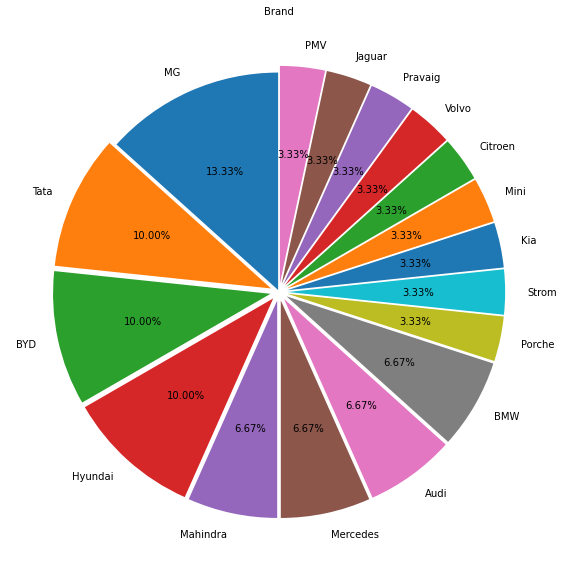

In [28]:
plt.figure(figsize=(10,10))
explode = [0.01,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04]
labels=['MG','Tata','BYD','Hyundai','Mahindra','Mercedes','Audi','BMW','Porche','Strom','Kia','Mini','Citroen','Volvo','Pravaig','Jaguar','PMV']
plt.pie(data['Brand'].value_counts(),labels=labels,autopct = '%.2f%%',startangle=90,explode=explode)
plt.title('Brand', fontsize = 10)

<AxesSubplot:xlabel='Car_price', ylabel='Drive_range'>

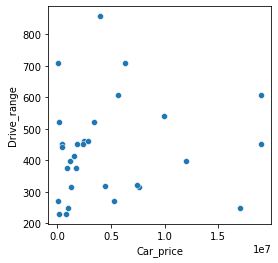

In [30]:
plt.figure(figsize=(4,4))
sns.scatterplot(x='Car_price',y='Drive_range',data=data)

<AxesSubplot:xlabel='Car_price', ylabel='Power'>

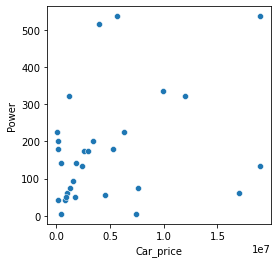

In [32]:
plt.figure(figsize=(4,4))
sns.scatterplot(x='Car_price',y='Power',data=data)

In [13]:

print(data.shape,"\n")
print(data.columns,"\n")
print(data.head(3))

(30, 7) 

Index(['Car_price', 'Batter_cap', 'Drive_range', 'Power', 'Charge_time',
       'Brand', 'Model'],
      dtype='object') 

   Car_price  Batter_cap  Drive_range  Power  Charge_time Brand Model
0   798000.0        17.3        230.0  41.42          7.0    MG    EV
1  1034000.0        19.2        250.0  60.34          7.0  Tata    EV
2  1312000.0        26.0        315.0  73.75          7.5  Tata    EV


In [14]:
# MEAN of each column

# Selecting the columns
selected_columns = ['Car_price', 'Batter_cap', 'Drive_range', 'Power', 'Charge_time']
MD_x = data[selected_columns].copy()
# Calculating the mean of the columns
mean_values = MD_x.mean().round(2)
print(mean_values)

Car_price      4698116.67
Batter_cap          69.15
Drive_range        432.70
Power              176.47
Charge_time          6.79
dtype: float64


In [15]:
pca = PCA()
pca.fit(MD_x)
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)
print("Cumulative explained variance:")
print(np.cumsum(pca.explained_variance_ratio_))
print("Factor loadings:")
print(pca.components_.T.round(1))

Explained variance ratio:
[9.99999998e-01 1.26606439e-09 2.18650679e-10 3.89226410e-11
 3.71492856e-13]
Cumulative explained variance:
[1. 1. 1. 1. 1.]
Factor loadings:
[[ 1.  -0.  -0.  -0.   0. ]
 [ 0.   0.2  0.3  0.9  0. ]
 [ 0.   0.7 -0.7  0.1 -0. ]
 [ 0.   0.7  0.7 -0.3 -0. ]
 [-0.  -0.  -0.  -0.   1. ]]


# Segment Extraction Using K-means Clustreing

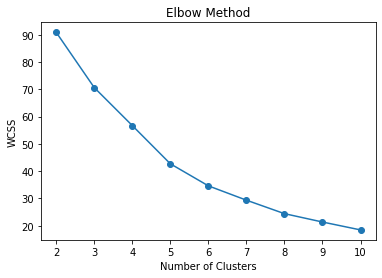

In [20]:
# Select the features for segmentation.
features = ['Car_price', 'Batter_cap', 'Drive_range', 'Power', 'Charge_time']
X = data[features]

# Normalize the features
X_norm = (X - X.mean()) / X.std()

# Perform K-means clustering with different numbers of clusters
wcss = []
max_clusters = 10
for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_norm)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(2, max_clusters+1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [21]:
# Perform K-means clustering with the optimal number of clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_norm)

data['Cluster'] = kmeans.labels_
cluster_counts = data['Cluster'].value_counts().sort_index()

# Print the number of samples for each cluster
print("Number of samples in each cluster:")
print(cluster_counts)

# Display each row with its corresponding cluster label
cluster_table = data[['Brand','Model','Car_price','Cluster']]
print(cluster_table)

Number of samples in each cluster:
0     3
1    16
2     4
3     7
Name: Cluster, dtype: int64
       Brand     Model   Car_price  Cluster
0         MG        EV    798000.0        1
1       Tata        EV   1034000.0        1
2       Tata        EV   1312000.0        1
3         MG        EV   2539000.0        3
4        BYD         3   3424000.0        3
5    Hyundai  Electric   2393500.0        1
6   Mahindra        EV   1749000.0        1
7       Tata       Max   1801500.0        3
8   Mercedes       EQS    199500.0        1
9       Audi        GT  17000000.0        1
10       BMW        i4   7570000.0        1
11       BYD        E6   2915000.0        3
12   Porsche    Taycan    191500.0        3
13      Audi        GT  19000000.0        1
14  Mahindra    Verito    929500.0        1
15     Strom        R3    450000.0        3
16      Tata     Prime   1584000.0        1
17   Hyundai         5   4495000.0        1
18       Kia       EV6   6345000.0        3
19       BMW        iX  1

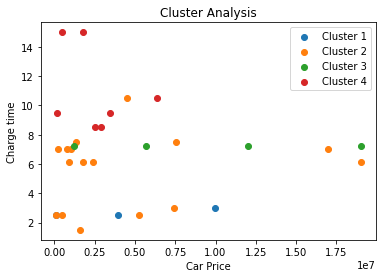

In [22]:

for cluster_label in range(num_clusters):
    cluster_samples = data[data['Cluster'] == cluster_label]
    plt.scatter(cluster_samples['Car_price'], cluster_samples['Charge_time'], label=f'Cluster {cluster_label+1}')

plt.xlabel('Car Price')
plt.ylabel('Charge time')
plt.title('Cluster Analysis')
plt.legend()
plt.show()

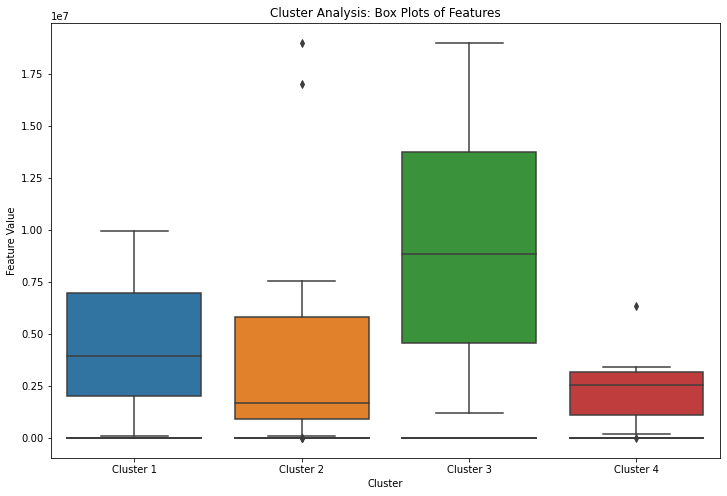

In [23]:
import seaborn as sns
# Create box plots for each feature grouped by cluster
plt.figure(figsize=(12, 8))
for feature in features:
    sns.boxplot(x=data['Cluster'], y=data[feature])
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.title('Cluster Analysis: Box Plots of Features')
plt.xticks(range(num_clusters), labels=['Cluster {}'.format(i+1) for i in range(num_clusters)])
plt.show()


#  Profiling and describing potential segments.

In [24]:
cluster_profiles = data.groupby('Cluster')[features].mean()
# Describe the potential segments
for cluster_label, profile in cluster_profiles.iterrows():
    print(f"Segment {cluster_label+1}:")
    print(profile)
    print()
     

Segment 1:
Car_price      4.670333e+06
Batter_cap     8.970000e+01
Drive_range    7.021667e+02
Power          3.591333e+02
Charge_time    2.666667e+00
Name: 0, dtype: float64

Segment 2:
Car_price      4.460219e+06
Batter_cap     3.908125e+01
Drive_range    3.302812e+02
Power          7.758563e+01
Charge_time    5.633750e+00
Name: 1, dtype: float64

Segment 3:
Car_price      9475750.00
Batter_cap         200.00
Drive_range        503.00
Power              429.12
Charge_time          7.25
Name: 2, dtype: float64

Segment 4:
Car_price      2.523714e+06
Batter_cap     5.428000e+01
Drive_range    5.111429e+02
Power          1.798429e+02
Charge_time    1.092857e+01
Name: 3, dtype: float64



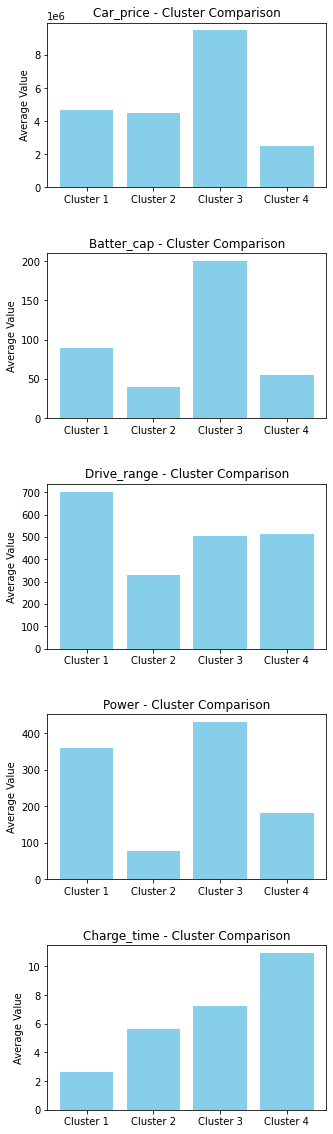

In [25]:
# Get the number of features and clusters
num_features = len(features)
num_clusters = cluster_profiles.shape[0]

# Create a bar chart for each feature
fig, axs = plt.subplots(num_features, 1, figsize=(5, 4*num_features))
fig.subplots_adjust(hspace=0.4)

# Plotting each feature's bar chart
for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'{feature} - Cluster Comparison')
    ax.bar(np.arange(num_clusters), cluster_profiles[feature], color='skyblue')
    ax.set_xticks(np.arange(num_clusters))
    ax.set_xticklabels([f'Cluster {j+1}' for j in range(num_clusters)])
    ax.set_ylabel('Average Value')

plt.show()